In [31]:
# GAM (Generalized Additive Model) for MLB Pitcher Injury Prediction
# Three variants: Unmodifiable-only, Modifiable + Delta, and Combined

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LogisticGAM, s, f, te
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


## Step 1: Load and Prepare Data


In [32]:
# Load cleaned data
df = pd.read_csv('pitcher_data_w_injuries_cleaned.csv')
df['game_year'] = df['game_year'].astype(str)

# Split data: train (2018-2023), test (2024), forecast (2025)
train_df = df[df['game_year'].isin(['2018', '2019', '2020', '2021', '2022', '2023'])].copy()
test_df = df[df['game_year'] == '2024'].copy()
forecast_df = df[df['game_year'] == '2025'].copy()

# Define feature sets
variant1_features = ['age', 'birth_country', 'bmi', 'game_year', 'hand', 'height', 'prev_arm_inj_hist']
variant2_features = ['BB%', 'BB_max_spin', 'FB%', 'FB_max_ivb', 'FB_max_spin', 'FB_max_velo',
                     'first_year', 'game_year', 'num_bf', 'num_games', 'pitcher_role', 'vrel_sd',
                     'Δ_BB_avg_spin', 'Δ_BB_max_spin', 'Δ_FB_avg_hb', 'Δ_FB_max_ivb',
                     'Δ_FB_max_spin', 'Δ_OS_max_spin', 'Δ_num_bf']
# Variant 3: Combined features from variant 1 and variant 2
variant3_features = list(set(variant1_features + variant2_features))  # Remove duplicates


## Step 2: Prepare Features for Modeling


In [33]:
def prepare_data_for_modeling(df, feature_list, target='injury_next_year'):
    """Prepare data for GAM modeling."""
    available_features = [f for f in feature_list if f in df.columns]
    data = df[available_features + [target]].copy()
    
    categorical_features = []
    for col in available_features:
        if data[col].dtype == 'object' or col == 'game_year':
            categorical_features.append(col)
            data[col] = data[col].astype(str)
    
    # Handle missing values
    for col in available_features:
        if col not in categorical_features:
            if data[col].isna().sum() > 0:
                data[col] = data[col].fillna(data[col].median())
        else:
            if data[col].isna().sum() > 0:
                mode_val = data[col].mode()[0] if len(data[col].mode()) > 0 else 'Unknown'
                data[col] = data[col].fillna(mode_val)
    
    # Collapse rare categorical levels
    for col in categorical_features:
        value_counts = data[col].value_counts()
        valid_levels = value_counts[value_counts >= 5].index.tolist()
        if len(valid_levels) < len(value_counts):
            data[col] = data[col].apply(lambda x: x if x in valid_levels else 'Other')
    
    return data, available_features, categorical_features

# Prepare data for each variant
train_v1, features_v1, cat_v1 = prepare_data_for_modeling(train_df, variant1_features)
test_v1, _, _ = prepare_data_for_modeling(test_df, variant1_features)
forecast_v1, _, _ = prepare_data_for_modeling(forecast_df, variant1_features)

train_v2, features_v2, cat_v2 = prepare_data_for_modeling(train_df, variant2_features)
test_v2, _, _ = prepare_data_for_modeling(test_df, variant2_features)
forecast_v2, _, _ = prepare_data_for_modeling(forecast_df, variant2_features)

train_v3, features_v3, cat_v3 = prepare_data_for_modeling(train_df, variant3_features)
test_v3, _, _ = prepare_data_for_modeling(test_df, variant3_features)
forecast_v3, _, _ = prepare_data_for_modeling(forecast_df, variant3_features)


## Step 3: Build GAM Models


In [41]:
def build_gam_model(train_data, features, categorical_features, target='injury_next_year'):
    """
    Build GAM model using pygam with proper handling of categorical and continuous features.
    Uses smooth terms (s) for continuous variables and factor terms (f) for categorical variables.
    """
    from sklearn.preprocessing import LabelEncoder
    
    # Separate continuous and categorical features
    continuous_features = [f for f in features if f not in categorical_features]
    
    y = train_data[target].values
    
    # Prepare continuous features matrix
    X_cont_list = []
    for feat in continuous_features:
        X_cont_list.append(train_data[feat].values.reshape(-1, 1))
    
    if len(X_cont_list) > 0:
        X_cont = np.hstack(X_cont_list) if len(X_cont_list) > 1 else X_cont_list[0]
    else:
        X_cont = np.empty((len(train_data), 0))
    
    # Prepare categorical features - encode as integers for f() terms
    X_cat_dict = {}
    cat_encoders = {}
    for feat in categorical_features:
        if feat in features:
            le = LabelEncoder()
            encoded = le.fit_transform(train_data[feat].astype(str))
            X_cat_dict[feat] = encoded
            cat_encoders[feat] = le
    
    # Build GAM terms: smooth terms for continuous + factor terms for categorical
    terms = None
    
    # Add smooth terms for continuous features
    if X_cont.shape[1] > 0:
        terms = s(0, n_splines=8, lam=0.6)  # Start with first continuous feature
        for i in range(1, X_cont.shape[1]):
            terms = terms + s(i, n_splines=8, lam=0.6)  # lam controls smoothing
    
    # Add factor terms for categorical features
    cat_idx = X_cont.shape[1]  # Start categorical indices after continuous
    for feat in categorical_features:
        if feat in features:
            if terms is None:
                terms = f(cat_idx)
            else:
                terms = terms + f(cat_idx)
            cat_idx += 1
    
    # Combine continuous and categorical into single design matrix
    X_list = []
    if X_cont.shape[1] > 0:
        X_list.append(X_cont)
    
    for feat in categorical_features:
        if feat in features:
            X_list.append(X_cat_dict[feat].reshape(-1, 1))
    
    if len(X_list) > 0:
        X = np.hstack(X_list) if len(X_list) > 1 else X_list[0]
    else:
        raise ValueError("No features available for modeling")
    
    # Build and fit GAM model
    try:
        model = LogisticGAM(terms=terms, max_iter=500)
        model.fit(X, y)
        
        # Store metadata for prediction
        model.X_train = X
        model.y_train = y
        model.continuous_features = continuous_features
        model.categorical_features = categorical_features
        model.original_features = features
        model.cat_encoders = cat_encoders
        model.n_continuous = X_cont.shape[1]
        model.n_categorical = len([f for f in categorical_features if f in features])
        
        return model
    except Exception as e:
        # Fallback: try with fewer splines and more smoothing
        try:
            terms = None
            if X_cont.shape[1] > 0:
                terms = s(0, n_splines=6, lam=1.0)
                for i in range(1, X_cont.shape[1]):
                    terms = terms + s(i, n_splines=6, lam=1.0)
            
            cat_idx = X_cont.shape[1]
            for feat in categorical_features:
                if feat in features:
                    if terms is None:
                        terms = f(cat_idx)
                    else:
                        terms = terms + f(cat_idx)
                    cat_idx += 1
            
            model = LogisticGAM(terms=terms, max_iter=500)
            model.fit(X, y)
            
            model.X_train = X
            model.y_train = y
            model.continuous_features = continuous_features
            model.categorical_features = categorical_features
            model.original_features = features
            model.cat_encoders = cat_encoders
            model.n_continuous = X_cont.shape[1]
            model.n_categorical = len([f for f in categorical_features if f in features])
            
            return model
        except Exception as e2:
            # Final fallback: continuous only with linear terms
            if X_cont.shape[1] == 0:
                raise ValueError("No continuous features and categorical handling failed")
            
            try:
                terms = s(0, n_splines=5, lam=2.0)
                for i in range(1, X_cont.shape[1]):
                    terms = terms + s(i, n_splines=5, lam=2.0)
                
                model = LogisticGAM(terms=terms, max_iter=500)
                model.fit(X_cont, y)
                
                model.X_train = X_cont
                model.y_train = y
                model.continuous_features = continuous_features
                model.categorical_features = categorical_features
                model.original_features = features
                model.cat_encoders = {}
                model.n_continuous = X_cont.shape[1]
                model.n_categorical = 0
                
                return model
            except Exception as e3:
                raise Exception(f"Could not fit GAM model: {e3}")

# Build models for all variants
model_v1 = build_gam_model(train_v1, features_v1, cat_v1)
model_v2 = build_gam_model(train_v2, features_v2, cat_v2)
model_v3 = build_gam_model(train_v3, features_v3, cat_v3)


In [42]:
# Create wrapper to provide statsmodels-like summary
class GAMSummary:
    def __init__(self, gam_model, variant_name):
        self.gam_model = gam_model
        self.variant_name = variant_name
        self.nobs = len(gam_model.y_train)
        
        # Calculate metrics using training data
        X_train_use = gam_model.X_train
        y_pred_proba = gam_model.predict_proba(X_train_use)
        y_pred_proba = np.clip(y_pred_proba, 1e-10, 1 - 1e-10)
        y_true = gam_model.y_train
        
        # Log-likelihood
        self.llf = np.sum(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
        
        # Null model log-likelihood
        null_proba = y_true.mean()
        null_llf = np.sum(y_true * np.log(null_proba) + (1 - y_true) * np.log(1 - null_proba))
        
        # Pseudo R-squared (McFadden's)
        self.prsquared = 1 - (self.llf / null_llf) if null_llf != 0 else 0.0
        
        # AIC and BIC (approximate - GAM uses effective degrees of freedom)
        # Get effective degrees of freedom from model statistics
        if hasattr(gam_model, 'statistics_') and 'edof' in gam_model.statistics_:
            edf = gam_model.statistics_['edof']
        else:
            # Fallback: estimate based on number of features
            edf = gam_model.n_continuous + gam_model.n_categorical
        self.aic = -2 * self.llf + 2 * edf
        self.bic = -2 * self.llf + edf * np.log(self.nobs)
        
    def __str__(self):
        lines = []
        lines.append("=" * 80)
        lines.append(f"GAM (Generalized Additive Model) Results - {self.variant_name}")
        lines.append("=" * 80)
        lines.append(f"Dep. Variable:       injury_next_year   No. Observations:     {self.nobs}")
        lines.append(f"Model:                          GAM   Pseudo R-squ.:      {self.prsquared:.6f}")
        lines.append(f"Method:                      P-IRLS   Log-Likelihood:     {self.llf:.2f}")
        lines.append(f"                                                              AIC:                 {self.aic:.2f}")
        lines.append(f"                                                              BIC:                 {self.bic:.2f}")
        lines.append("=" * 80)
        return "\n".join(lines)

# Display model summaries
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (Combined)')]:
    model = globals()[f'model_v{variant}']
    summary = GAMSummary(model, name)
    print(f"\n{name} Summary:")
    print(str(summary))



Variant 1 (Unmodifiable) Summary:
GAM (Generalized Additive Model) Results - Variant 1 (Unmodifiable)
Dep. Variable:       injury_next_year   No. Observations:     4695
Model:                          GAM   Pseudo R-squ.:      0.032760
Method:                      P-IRLS   Log-Likelihood:     -2280.45
                                                              AIC:                 4630.48
                                                              BIC:                 4855.04

Variant 2 (Modifiable) Summary:
GAM (Generalized Additive Model) Results - Variant 2 (Modifiable)
Dep. Variable:       injury_next_year   No. Observations:     4695
Model:                          GAM   Pseudo R-squ.:      0.069585
Method:                      P-IRLS   Log-Likelihood:     -2193.62
                                                              AIC:                 4496.40
                                                              BIC:                 4848.65

Variant 3 (Combined) Summary:
G

In [43]:
# Generate predictions for all datasets
def get_predictions_gam(model, data, target='injury_next_year'):
    """Get predicted probabilities from GAM model."""
    try:
        # Prepare continuous features
        X_cont_list = []
        for feat in model.continuous_features:
            if feat in data.columns:
                X_cont_list.append(data[feat].values.reshape(-1, 1))
        
        if len(X_cont_list) > 0:
            X_cont = np.hstack(X_cont_list) if len(X_cont_list) > 1 else X_cont_list[0]
        else:
            X_cont = np.empty((len(data), 0))
        
        # Prepare categorical features using stored encoders
        X_cat_list = []
        for feat in model.categorical_features:
            if feat in model.original_features and feat in data.columns:
                if feat in model.cat_encoders:
                    le = model.cat_encoders[feat]
                    # Handle unseen categories by mapping to most common category
                    cat_values = data[feat].astype(str)
                    known_classes = set(le.classes_)
                    # Replace unknown categories with the first known category
                    cat_values = cat_values.apply(lambda x: x if x in known_classes else le.classes_[0])
                    encoded = le.transform(cat_values)
                    X_cat_list.append(encoded.reshape(-1, 1))
        
        # Combine continuous and categorical features
        X_list = []
        if X_cont.shape[1] > 0:
            X_list.append(X_cont)
        X_list.extend(X_cat_list)
        
        if len(X_list) > 0:
            X_new = np.hstack(X_list) if len(X_list) > 1 else X_list[0]
        else:
            return np.full(len(data), np.nan)
        
        # Ensure correct number of features
        expected_n_features = model.n_continuous + model.n_categorical
        if X_new.shape[1] != expected_n_features:
            # This shouldn't happen if features are consistent, but handle it
            if X_new.shape[1] < expected_n_features:
                # Pad with zeros (shouldn't happen in practice)
                padding = np.zeros((X_new.shape[0], expected_n_features - X_new.shape[1]))
                X_new = np.hstack([X_new, padding])
            elif X_new.shape[1] > expected_n_features:
                # Truncate (shouldn't happen in practice)
                X_new = X_new[:, :expected_n_features]
        
        predictions = model.predict_proba(X_new)
        
        # Convert to numpy array and ensure probabilities
        predictions = np.array(predictions).flatten()
        predictions = np.clip(predictions, 0, 1)
        predictions = np.nan_to_num(predictions, nan=np.nan)
        return predictions
    except Exception as e:
        import traceback
        print(f"Error in prediction: {e}")
        print(traceback.format_exc())
        return np.full(len(data), np.nan)

# Generate predictions
train_pred_v1 = get_predictions_gam(model_v1, train_v1)
train_pred_v2 = get_predictions_gam(model_v2, train_v2)
train_pred_v3 = get_predictions_gam(model_v3, train_v3)

test_pred_v1 = get_predictions_gam(model_v1, test_v1)
test_pred_v2 = get_predictions_gam(model_v2, test_v2)
test_pred_v3 = get_predictions_gam(model_v3, test_v3)

forecast_pred_v1 = get_predictions_gam(model_v1, forecast_v1)
forecast_pred_v2 = get_predictions_gam(model_v2, forecast_v2)
forecast_pred_v3 = get_predictions_gam(model_v3, forecast_v3)


In [44]:
# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    """Calculate calibration-focused metrics."""
    valid_mask = ~np.isnan(y_pred)
    if valid_mask.sum() == 0:
        return None
    
    y_true_clean = y_true[valid_mask]
    y_pred_clean = y_pred[valid_mask]
    
    if len(y_true_clean) == 0 or y_pred_clean.std() == 0:
        return None
    
    metrics = {
        'log_loss': log_loss(y_true_clean, y_pred_clean),
        'brier_score': brier_score_loss(y_true_clean, y_pred_clean),
        'roc_auc': roc_auc_score(y_true_clean, y_pred_clean) if len(np.unique(y_true_clean)) > 1 else np.nan,
        'mean_pred': y_pred_clean.mean(),
        'actual_rate': y_true_clean.mean()
    }
    return metrics

# Calculate metrics for all variants
results = {}
variant_names = {1: 'Variant 1 (Unmodifiable)', 2: 'Variant 2 (Modifiable)', 3: 'Variant 3 (Combined)'}
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (Combined)')]:
    results[name] = {}
    
    train_data = globals()[f'train_v{variant}']
    test_data = globals()[f'test_v{variant}']
    
    train_pred = globals()[f'train_pred_v{variant}']
    train_metrics = calculate_metrics(train_data['injury_next_year'].values, train_pred)
    results[name]['train'] = train_metrics
    
    test_pred = globals()[f'test_pred_v{variant}']
    test_metrics = calculate_metrics(test_data['injury_next_year'].values, test_pred)
    results[name]['test'] = test_metrics

# Display results as DataFrame
variant_labels = {1: 'Unmodifiable', 2: 'Modifiable', 3: 'Combined'}
metrics_df = pd.DataFrame({
    'Variant': ['Variant 1', 'Variant 2', 'Variant 3'],
    'Train Log Loss': [results[variant_names[i]]['train']['log_loss'] for i in [1,2,3]],
    'Test Log Loss': [results[variant_names[i]]['test']['log_loss'] for i in [1,2,3]],
    'Train Brier Score': [results[variant_names[i]]['train']['brier_score'] for i in [1,2,3]],
    'Test Brier Score': [results[variant_names[i]]['test']['brier_score'] for i in [1,2,3]],
    'Train ROC-AUC': [results[variant_names[i]]['train']['roc_auc'] for i in [1,2,3]],
    'Test ROC-AUC': [results[variant_names[i]]['test']['roc_auc'] for i in [1,2,3]]
})
print(metrics_df.to_string(index=False))


  Variant  Train Log Loss  Test Log Loss  Train Brier Score  Test Brier Score  Train ROC-AUC  Test ROC-AUC
Variant 1        0.485718       0.527120           0.155629          0.172393       0.622179      0.563225
Variant 2        0.467226       0.523171           0.149816          0.171495       0.684709      0.608587
Variant 3        0.456276       0.519053           0.146427          0.170820       0.710758      0.627098


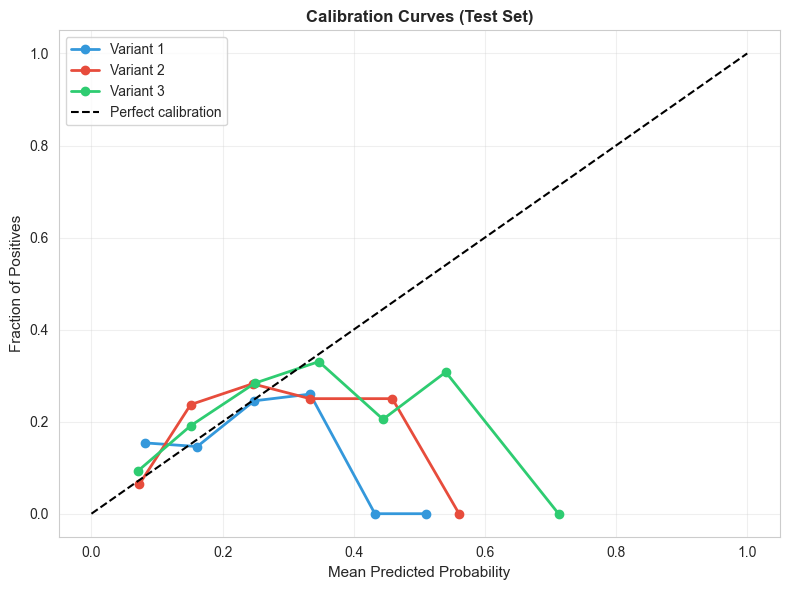

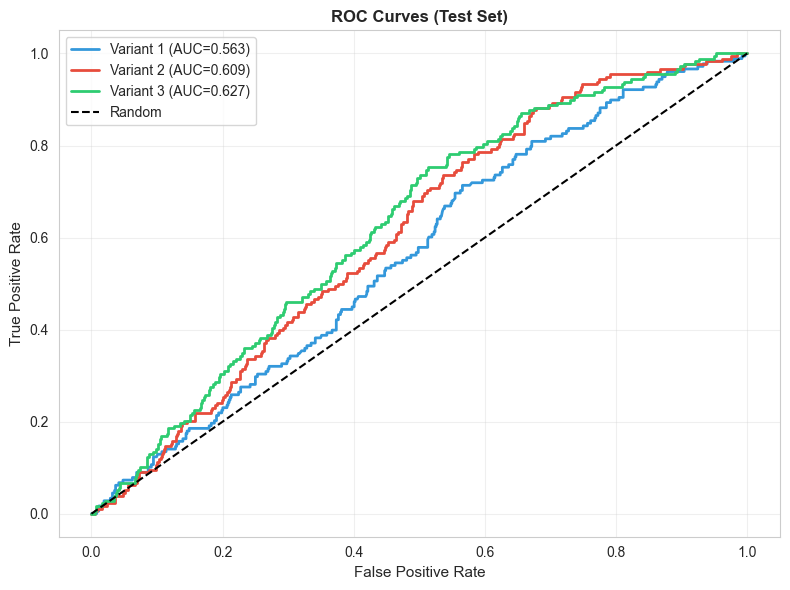

In [45]:
# Visualization: Calibration curves for test set
fig1, ax1 = plt.subplots(figsize=(8, 6))
for variant, name, color in [(1, 'Variant 1', '#3498db'), (2, 'Variant 2', '#e74c3c'), (3, 'Variant 3', '#2ecc71')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        if len(np.unique(y_true_clean)) > 1:
            fraction_of_positives, mean_predicted_value = calibration_curve(
                y_true_clean, y_pred_clean, n_bins=10, strategy='uniform'
            )
            ax1.plot(mean_predicted_value, fraction_of_positives, 'o-', label=name, color=color, linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', linewidth=1.5)
ax1.set_xlabel('Mean Predicted Probability', fontsize=11)
ax1.set_ylabel('Fraction of Positives', fontsize=11)
ax1.set_title('Calibration Curves (Test Set)', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: ROC curves for test set
fig2, ax2 = plt.subplots(figsize=(8, 6))
for variant, name, color in [(1, 'Variant 1', '#3498db'), (2, 'Variant 2', '#e74c3c'), (3, 'Variant 3', '#2ecc71')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        if len(np.unique(y_true_clean)) > 1:
            fpr, tpr, _ = roc_curve(y_true_clean, y_pred_clean)
            auc = roc_auc_score(y_true_clean, y_pred_clean)
            ax2.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1.5)
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curves (Test Set)', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [46]:
# Model fit statistics using statsmodels-like format
fit_stats = []
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (Combined)')]:
    model = globals()[f'model_v{variant}']
    summary = GAMSummary(model, name)
    
    fit_stats.append({
        'Model': name,
        'AIC': f"{summary.aic:.2f}",
        'BIC': f"{summary.bic:.2f}",
        'Log-Likelihood': f"{summary.llf:.2f}",
        'Pseudo R²': f"{summary.prsquared:.4f}",
        'N': summary.nobs
    })
print("Model Fit Statistics:")
print(pd.DataFrame(fit_stats).to_string(index=False))

# Test set performance metrics
perf_metrics = []
for variant, name in [(1, 'Variant 1 (Unmodifiable)'), (2, 'Variant 2 (Modifiable)'), (3, 'Variant 3 (Combined)')]:
    test_pred = globals()[f'test_pred_v{variant}']
    test_data = globals()[f'test_v{variant}']
    test_true = test_data['injury_next_year'].values
    valid_mask = ~np.isnan(test_pred)
    
    if valid_mask.sum() > 0:
        y_true_clean = test_true[valid_mask]
        y_pred_clean = test_pred[valid_mask]
        
        perf_metrics.append({
            'Model': name,
            'Log Loss': f"{log_loss(y_true_clean, y_pred_clean):.4f}",
            'Brier Score': f"{brier_score_loss(y_true_clean, y_pred_clean):.4f}",
            'ROC-AUC': f"{roc_auc_score(y_true_clean, y_pred_clean):.4f}" if len(np.unique(y_true_clean)) > 1 else 'N/A',
            'Mean Predicted': f"{y_pred_clean.mean():.4f}",
            'Actual Rate': f"{y_true_clean.mean():.4f}"
        })

print("\nTest Set Performance Metrics:")
print(pd.DataFrame(perf_metrics).to_string(index=False))


Model Fit Statistics:
                   Model     AIC     BIC Log-Likelihood Pseudo R²    N
Variant 1 (Unmodifiable) 4630.48 4855.04       -2280.45    0.0328 4695
  Variant 2 (Modifiable) 4496.40 4848.65       -2193.62    0.0696 4695
    Variant 3 (Combined) 4449.83 4983.57       -2142.22    0.0914 4695

Test Set Performance Metrics:
                   Model Log Loss Brier Score ROC-AUC Mean Predicted Actual Rate
Variant 1 (Unmodifiable)   0.5271      0.1724  0.5632         0.2399      0.2219
  Variant 2 (Modifiable)   0.5232      0.1715  0.6086         0.1877      0.2219
    Variant 3 (Combined)   0.5191      0.1708  0.6271         0.2136      0.2219


In [ ]:
## Step 6: Diagnose Why Improvement is Marginal - Partial Dependence Analysis

# Create partial dependence plots to see if smooth terms are actually non-linear
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

plot_idx = 0
for variant, name in [(1, 'Variant 1'), (2, 'Variant 2'), (3, 'Variant 3')]:
    model = globals()[f'model_v{variant}']
    
    # Plot partial dependence for first few continuous features
    for i, feat in enumerate(model.continuous_features[:2]):
        if plot_idx < len(axes):
            ax = axes[plot_idx]
            try:
                # Get partial dependence
                XX = model.generate_X_grid(term=i)
                pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95)
                
                ax.plot(XX[:, i], pdep, linewidth=2, label=f'{name} - {feat}')
                ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.3)
                ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
                ax.set_xlabel(feat, fontsize=10)
                ax.set_ylabel('Partial Dependence', fontsize=10)
                ax.set_title(f'Partial Dependence: {feat}', fontweight='bold', fontsize=11)
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=8)
            except Exception as e:
                ax.text(0.5, 0.5, f'Error plotting {feat}', 
                       ha='center', va='center', transform=ax.transAxes)
            plot_idx += 1

# Remove unused subplots
for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Partial Dependence Plots: Are Relationships Non-Linear?', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Check effective degrees of freedom (EDF) - if EDF ≈ 1, relationship is linear
print("\n" + "="*80)
print("Effective Degrees of Freedom (EDF) Analysis")
print("="*80)
print("EDF ≈ 1: Linear relationship")
print("EDF > 2: Non-linear relationship detected")
print("="*80)

for variant, name in [(1, 'Variant 1'), (2, 'Variant 2'), (3, 'Variant 3')]:
    model = globals()[f'model_v{variant}']
    print(f"\n{name}:")
    if hasattr(model, 'statistics_') and 'edof' in model.statistics_:
        edof = model.statistics_['edof']
        print(f"  Total EDF: {edof:.2f}")
        print(f"  Number of continuous features: {model.n_continuous}")
        print(f"  Average EDF per smooth term: {edof / max(model.n_continuous, 1):.2f}")
        
        # Check if smooth terms are essentially linear
        if edof / max(model.n_continuous, 1) < 1.5:
            print(f"  → Smooth terms are mostly LINEAR (EDF < 1.5 per term)")
        else:
            print(f"  → Non-linear relationships detected (EDF > 1.5 per term)")
    else:
        print("  EDF information not available")

print("\n" + "="*80)
print("Interpretation:")
print("If EDF per smooth term is close to 1, the relationships are linear")
print("and GAM won't provide much advantage over logistic regression.")
print("="*80)
